In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
# Import stuff from pone, which includes the code written for this project
from pone.utils import design_matrix, franke_function, mse
from pone.models import OLSRegression
from pone.resamplers import Bootstrapper
from pone.data_generation import create_terrain_data

In [3]:
np.random.seed(2024)
bs = Bootstrapper(model=LinearRegression(), degree=20)

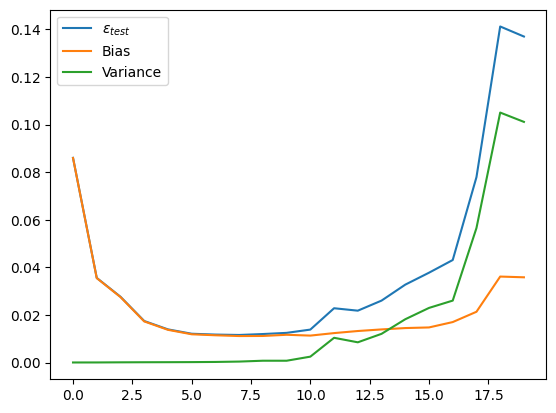

In [4]:
x1_ = np.sort(np.random.uniform(0, 1, 40))
x2_ = np.sort(np.random.uniform(0, 1, 40))
x1, x2 = np.meshgrid(x1_, x2_)
y = franke_function(x1, x2, 1)

p_degrees, error_test, bias, variance = bs.train_loop(x1.ravel(), x2.ravel(), y.ravel())

fig, ax = plt.subplots()
# ax.plot(degrees, error_train, label=r"$\epsilon_{train}$")
ax.plot(p_degrees, error_test, label=r"$\epsilon_{test}$")
ax.plot(p_degrees, bias, label="Bias")
ax.plot(p_degrees, variance, label="Variance")
# ax.set_yscale("log")
ax.legend()
plt.show()

In [3]:
x = np.random.rand(100).reshape(-1, 1)
noise = np.random.normal(0, 0.1, x.shape)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2) + noise 

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = OLSRegression()
model.fit(X_train, y_train)

In [6]:
model.beta

array([[1.42361862]])

In [14]:
x1_ = np.sort(np.random.uniform(0, 1, 40))
x2_ = np.sort(np.random.uniform(0, 1, 40))
x1, x2 = np.meshgrid(x1_, x2_)
y = franke_function(x1, x2, 1)

X = np.column_stack((x1.ravel(), x2.ravel()))
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2)

In [15]:
degree = 5
n_bootstraps = 100

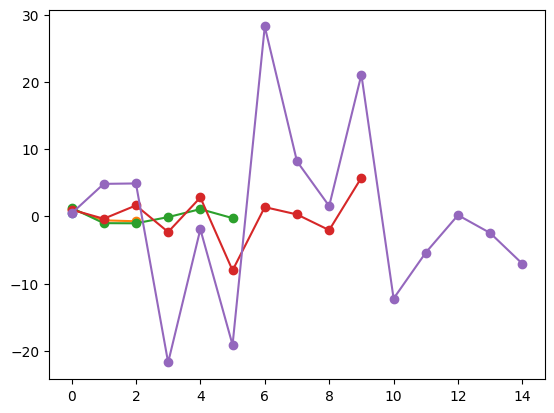

In [21]:
x1_train = X_train[:, 0]
x2_train = X_train[:, 1]

x1_test = X_test[:, 0]
x2_test = X_test[:, 1]

model = OLSRegression()
beta = np.zeros(degree)
error_test = np.zeros(degree)
bias = np.zeros(degree)
variance = np.zeros(degree)

fig, ax = plt.subplots()

for p in range(degree):
    Xtrain = design_matrix([x1_train, x2_train], p)
    Xtest = design_matrix([x1_test, x2_test], p)

    model.fit(Xtrain, y_train)
    y_pred = model.predict(Xtest)

    ax.plot(model.beta, 'o-')

    error_test[p] = mse(y_test, y_pred)
    bias[p] = np.mean((y_test - np.mean(y_pred))**2)
    variance[p] = np.mean(np.var(y_pred))

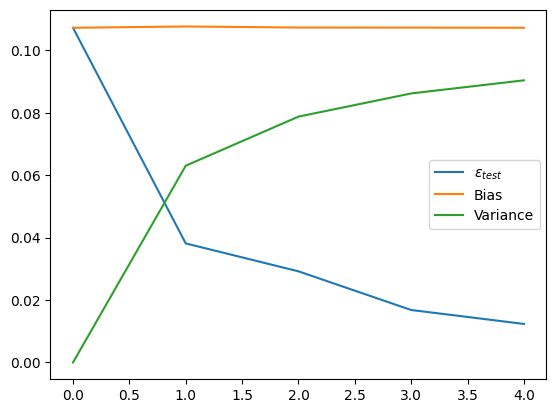

In [20]:
p_degrees = np.arange(degree)

fig, ax = plt.subplots()
# ax.plot(degrees, error_train, label=r"$\epsilon_{train}$")
ax.plot(p_degrees, error_test, label=r"$\epsilon_{test}$")
ax.plot(p_degrees, bias, label="Bias")
ax.plot(p_degrees, variance, label="Variance")
# ax.set_yscale("log")
ax.legend()
plt.show()

## Terrain data
Explore model prediction on real data.

In [136]:
from imageio.v3 import imread
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def design_matrix(x, y, degree):
	"""Create design matrix for polynomial degree n with dimension determined
	by the size of input arrays and degree.
	
	Args:
	    x (np.ndarray): x-values, 1D or 2D array
		y (np.ndarray): y-values, 1D or 2D array
        degree (int): order of polynomial degree
		
	Returns:
        np.ndarray: array with shape (len(x)*len(y), degree)
    """
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	# Number of elements in beta
	l = int((degree+1)*(degree+2) / 2)
	X = np.ones((N,l))

	for i in range(1,degree+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

def create_terrain_data(n, filename):
	"""Load terrain data from file.
	
	Args:
		n (int): number of lines to load from file
        filename (str): filename to create data from
		
	Returns:
        tuple: arrays of input and output data
	"""
	x1_ = np.sort(np.random.uniform(0, 1, n))
	x2_ = np.sort(np.random.uniform(0, 1, n))
	x1, x2= np.meshgrid(x1_, x2_)

	data = f'../data/{filename}'
	terrain = imread(data)

	# scaled = (terrain - terrain.mean()) / terrain.std()
	
	y = np.zeros((n, n))
	for i in range(n):
		for j in range(n):
			y[i, j] = terrain[i, j]


	# Create x and y
	# x1_ = np.sort(np.random.uniform(0, 1, n))
	# x2_ = np.sort(np.random.uniform(0, 1, n))
	# x1, x2= np.meshgrid(x1_, x2_)
	
	return (x1.ravel(), x2.ravel(), y.ravel())

In [137]:
x1, x2, y = create_terrain_data(20, 'n34_e135_1arc_v3.tif')
model = OLSRegression()

In [138]:
y_scaled = (y - np.min(y)) / (np.max(y) - np.min(y))

In [139]:
degrees = np.arange(10)
error = np.zeros_like(degrees)

In [143]:
from sklearn.metrics import mean_squared_error


for p in degrees:
    X = design_matrix(x1, x2, p)
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    error[p] = mse(y_test, y_pred)

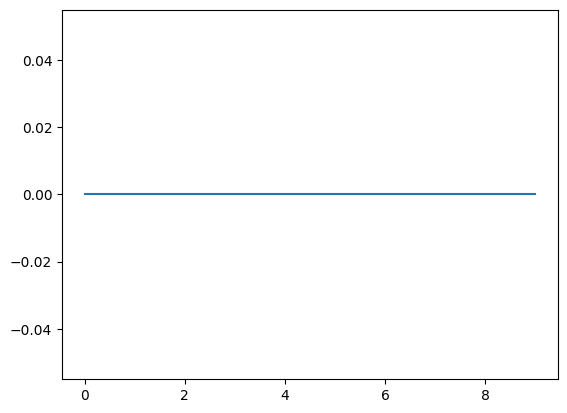

In [144]:
fig, ax = plt.subplots()
ax.plot(degrees, error)
plt.show()

In [20]:
X = design_matrix([x1, x2], p)
y_franke = franke_function(x1, x2, 0.5)

# X = np.column_stack((x1, x2))
X_train, X_test, y_train, y_test = train_test_split(X, y_franke, test_size=0.2)



In [21]:
model = OLSRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [22]:
mse(y_test, y_pred)

0.0026639019721733785

In [24]:
X_real = np.column_stack((x1, x2))
y_real = model.predict(X_real)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 21 is different from 2)

In [4]:
X = np.column_stack((x1, x2))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = OLSRegression()
model.fit(X_train, y_train)

In [5]:
y_pred = model.predict(X_test)
mse(y_test, y_pred)

919.4469266452176

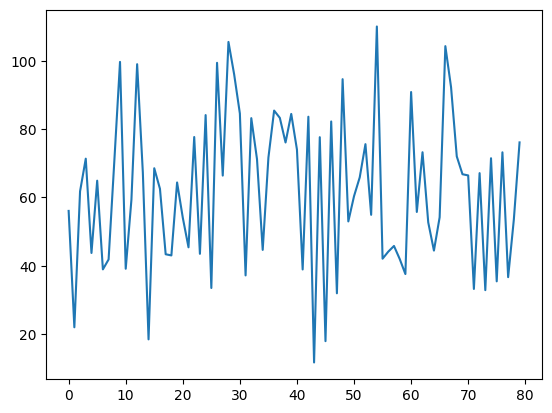

In [6]:
plt.plot(y_pred)